### Class for GD Optimizer

#### * The optimizer is a mini-batch version. Setting the batch size to 1 makes it follow stochastic gradient descent (SGD), and setting the batch size to len(data) makes it full-batch gradient descent.

#### * The optimizer has two accelerated gradient descent options:

#### 1- Momentum-based, achieved by setting the accelerated parameter to 1.

#### 2- Nesterov Accelerated Gradient (NAG), achieved by setting the accelerated parameter to 2.

In [62]:
#Imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [370]:
def loss_vs_iterations(cost_history):
    plt.figure(figsize=(10, 8))
    plt.plot(cost_history, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss VS. Iterations')
    plt.grid(True)
    plt.show()    
    
def theta_vs_cost(theta_history, cost_history):
    theta_history = np.array(theta_history)
    num_thetas = theta_history.shape[1]
    
    plt.figure(figsize=(15, 5))
    for i in range(num_thetas):
        plt.subplot(1, num_thetas, i + 1)
        plt.plot(theta_history[:, i], cost_history, marker='x')
        plt.title(f'Theta{i}')
        plt.xlabel(f'Theta{i}')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.tight_layout()
    
    plt.show()

In [89]:
class MiniBatchGD:
    def __init__(self, epochs = 100, stop_threshold=0.001, convergence_check=0.001, learning_rate=0.01, batch_size=1, accelerated=0, gamma=0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accelerated = accelerated
        self.gamma = gamma
        self.stop_threshold = stop_threshold
        self.convergence_check = convergence_check
        self.epochs = epochs
        self.thetas = None

    def _prepare_input(self, X):
        if len(X.shape) == 1:
            return X.reshape(-1, 1)
        else:
            return X.reshape(-1, X.shape[1])

    def fit(self, X,y):
        if self.gamma > 1 or self.gamma < 0:
            raise ValueError("Gamma should be a value between 0 and 1.")
        if self.batch_size < 1:
            raise ValueError("Batch size must be greater than 1.")
        X = self._prepare_input(X)
        y = y.reshape(-1, 1)
        ones_column = np.ones((X.shape[0], 1))
        X = np.concatenate((ones_column, X), axis=1)
        self.thetas = np.zeros((X.shape[1], 1))
        vt = np.zeros_like(self.thetas)
        cost_history = []
        epochs_cost_history = []
        hx_history = []
        thetas_history = []
        batches_x = np.array_split(X, len(X) // self.batch_size)
        batches_y = np.array_split(y, len(y) // self.batch_size)
        for i in range(self.epochs):
            for batch_x, batch_y in zip(batches_x, batches_y):
                thetas_history.append(self.thetas)
                hx = np.dot(batch_x, self.thetas)
                hx_history.append(hx)
                error = hx - batch_y
                norm_squared = np.linalg.norm(error) ** 2
                j = norm_squared / (2 * len(batch_y))
                cost_history.append(j)
                gradient_vector = np.dot(batch_x.T, error) / len(batch_y)

                if self.accelerated == 0:  # GD
                    self.thetas = self.thetas - (self.learning_rate * gradient_vector)
                elif self.accelerated == 1:  # Momentum
                    vt = (self.gamma * vt) + (self.learning_rate * gradient_vector)
                    self.thetas = self.thetas - vt
                elif self.accelerated == 2:  # NAG
                    thetas_temp = self.thetas - self.gamma * vt
                    hx_temp = np.dot(batch_x, thetas_temp)
                    error_temp = hx_temp - batch_y
                    gradient_temp = np.dot(batch_x.T, error_temp) / len(batch_y)
                    vt = (self.gamma * vt) + (self.learning_rate * gradient_temp)
                    self.thetas = thetas_temp - self.learning_rate * gradient_temp

            epochs_cost_history.append(j)

            if np.linalg.norm(gradient_vector) < self.stop_threshold:
                break

            if i > 0 and abs(epochs_cost_history[-2] - epochs_cost_history[-1]) < self.convergence_check:
                break

        training_report = {
            "convergence_epochs": i + 1,
            "thetas": self.thetas.tolist(),
            "cost": j,
            "h_x": np.dot(X, self.thetas).tolist(),
            "y_actual": y.tolist()
        }
        
        return self.thetas, thetas_history, hx_history, cost_history, training_report
    def predict(self, X):
        if self.thetas is None:
            raise RuntimeError("Model has not been fitted. Please call fit method first.")
        X = self._prepare_input(X)
        ones_column = np.ones((X.shape[0], 1))
        X = np.concatenate((ones_column, X), axis=1)
        return np.dot(X, self.thetas)

### Using the model

##### Generating the Data

In [346]:
np.random.seed(42)

num_samples = 250
random_numbers = np.random.rand(num_samples)

X1 = 3 * random_numbers + 2
X2 = 5 * random_numbers - 1
X3 = 4 * random_numbers + 0.5

noise = np.random.normal(0, 1, num_samples)
y = 2 * X1 - 3 * X2 + 5 * X3 + noise

synthetic_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'Target': y})

print(synthetic_data.head())

         X1        X2        X3     Target
0  3.123620  0.872701  1.998160  12.773148
1  4.852143  3.753572  4.302857  18.443010
2  4.195982  2.659970  3.427976  17.105418
3  3.795975  1.993292  2.894634  16.941642
4  2.468056 -0.219907  1.124075  11.430299


In [347]:
X = synthetic_data[['X1', 'X2', 'X3']].values
y = synthetic_data['Target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Epochs = 300, LR = 0.01, full data, no acceleration

In [371]:
model = MiniBatchGD(epochs=300, learning_rate=0.01, batch_size=len(X_train), accelerated=0, gamma=0)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)
hx = model.predict(X_train)
y_pred = model.predict(X_test)

In [372]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9088261202988364
Test R2 Score: 0.900233250949913
Root Mean Squared Error: 1.0266609508469018
Root Mean Squared Error for baseline: 3.2503799735966448


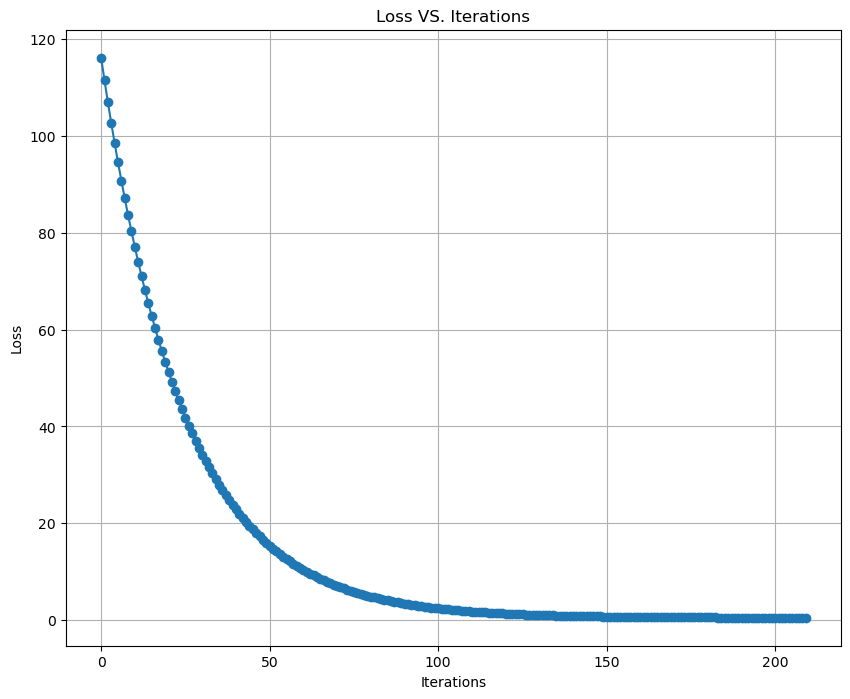

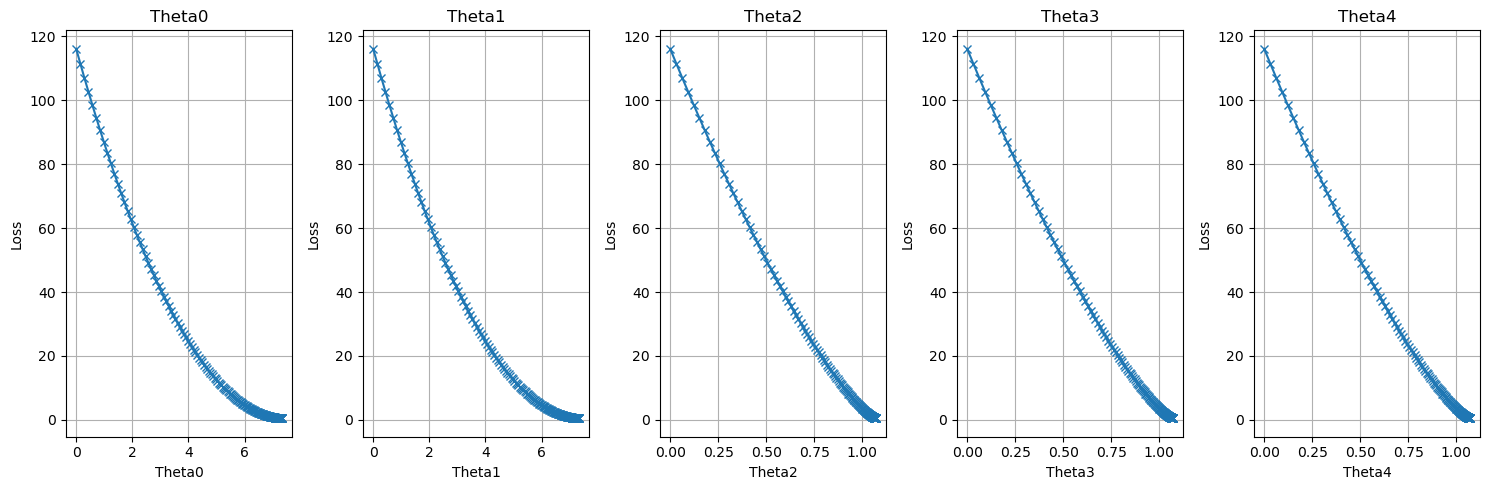

In [373]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.1, full data, no acceleration

In [374]:
model = MiniBatchGD(epochs=300, learning_rate=0.1, batch_size=len(X_train), accelerated=0, gamma=0)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)
hx = model.predict(X_train)
y_pred = model.predict(X_test)

In [375]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9075401809497192
Root Mean Squared Error: 0.9883497417174073
Root Mean Squared Error for baseline: 3.2503799735966448


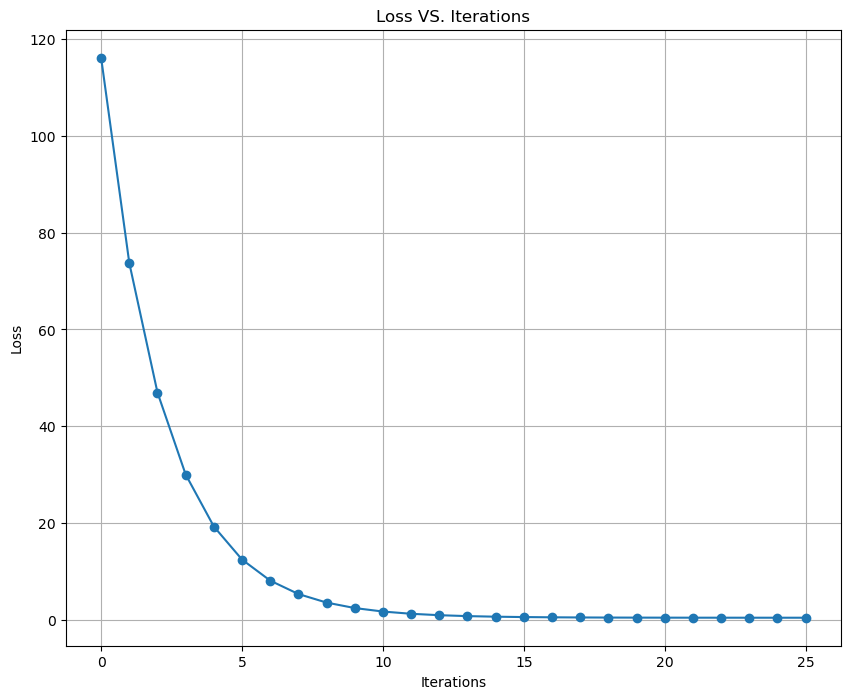

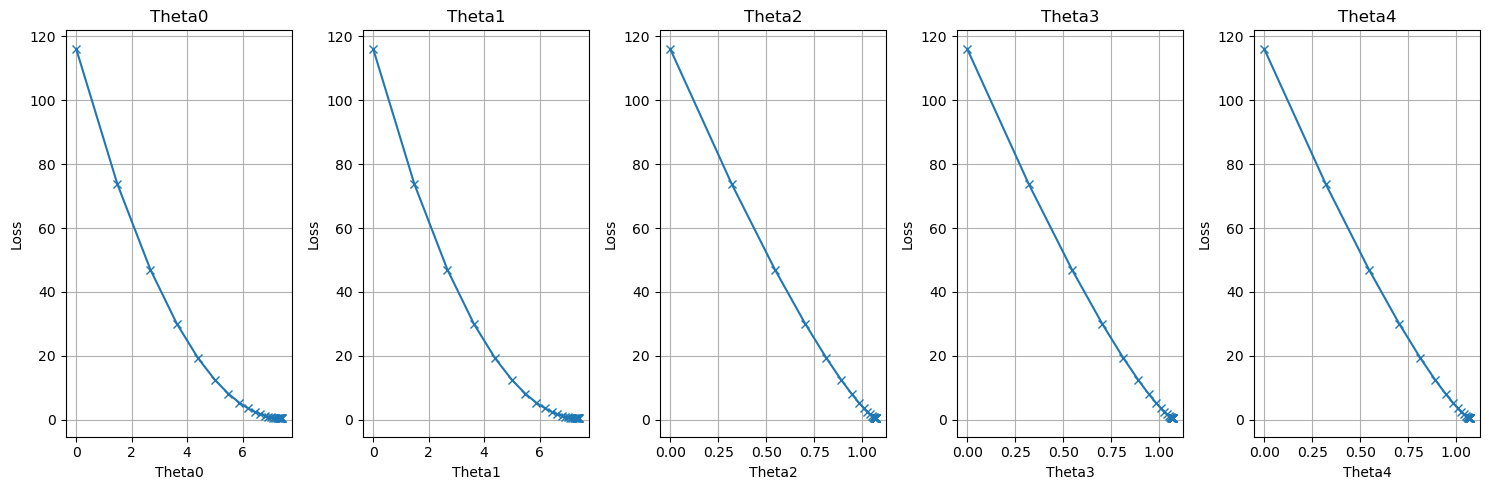

In [376]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 500, LR = 0.1, full data, no acceleration

In [377]:
model = MiniBatchGD(epochs=500, learning_rate=0.1, batch_size=len(X_train), accelerated=0, gamma=0)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)
hx = model.predict(X_train)
y_pred = model.predict(X_test)

In [378]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9075401809497192
Root Mean Squared Error: 0.9883497417174073
Root Mean Squared Error for baseline: 3.2503799735966448


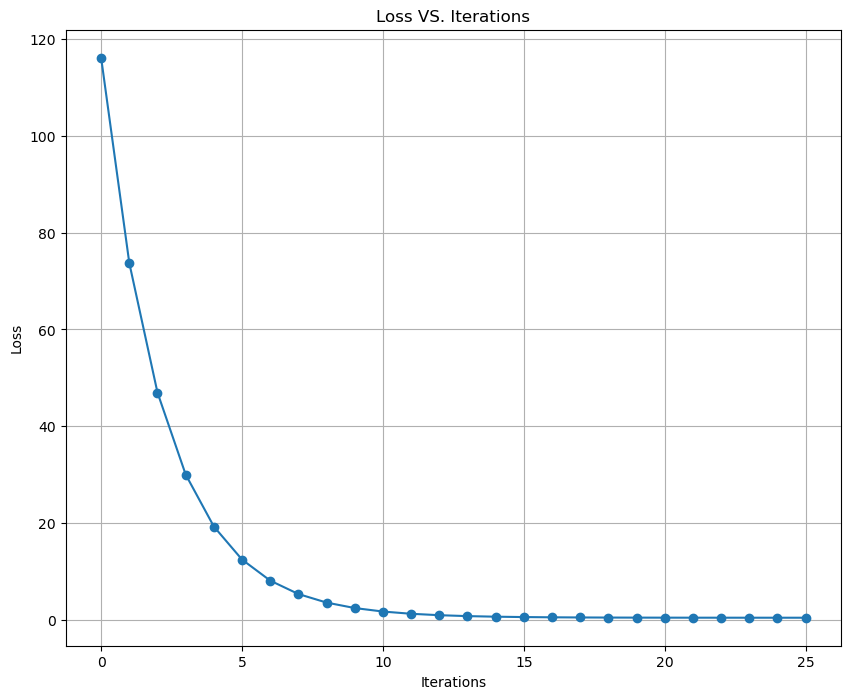

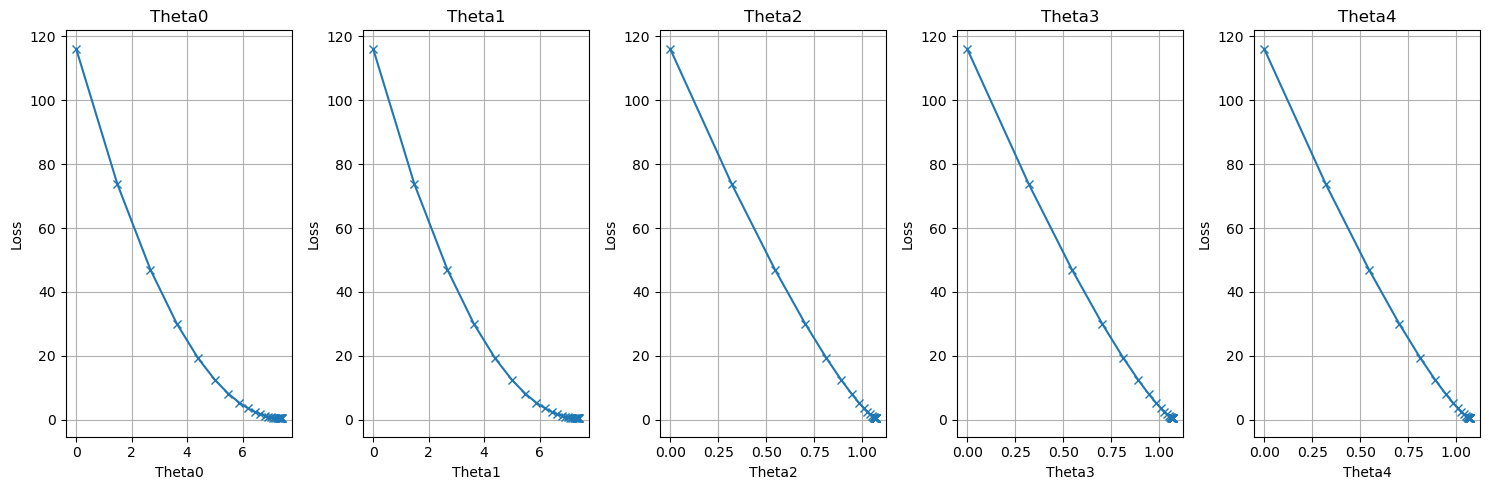

In [379]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.1, batch size = 32, no acceleration

In [380]:
model = MiniBatchGD(epochs=300, learning_rate=0.1, batch_size=32, accelerated=0, gamma=0)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [381]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9082187517984233
Root Mean Squared Error: 0.984716269446138
Root Mean Squared Error for baseline: 3.2503799735966448


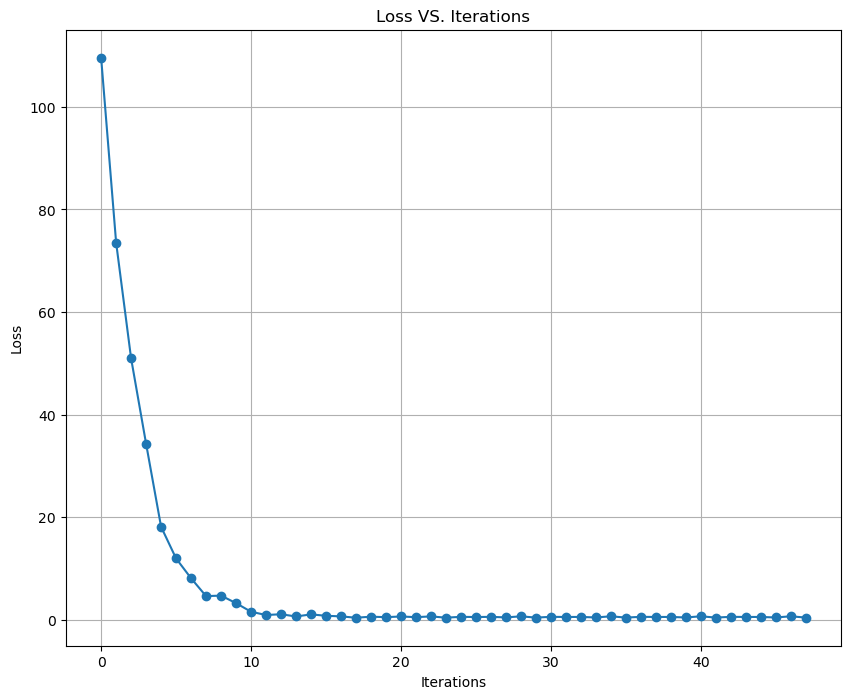

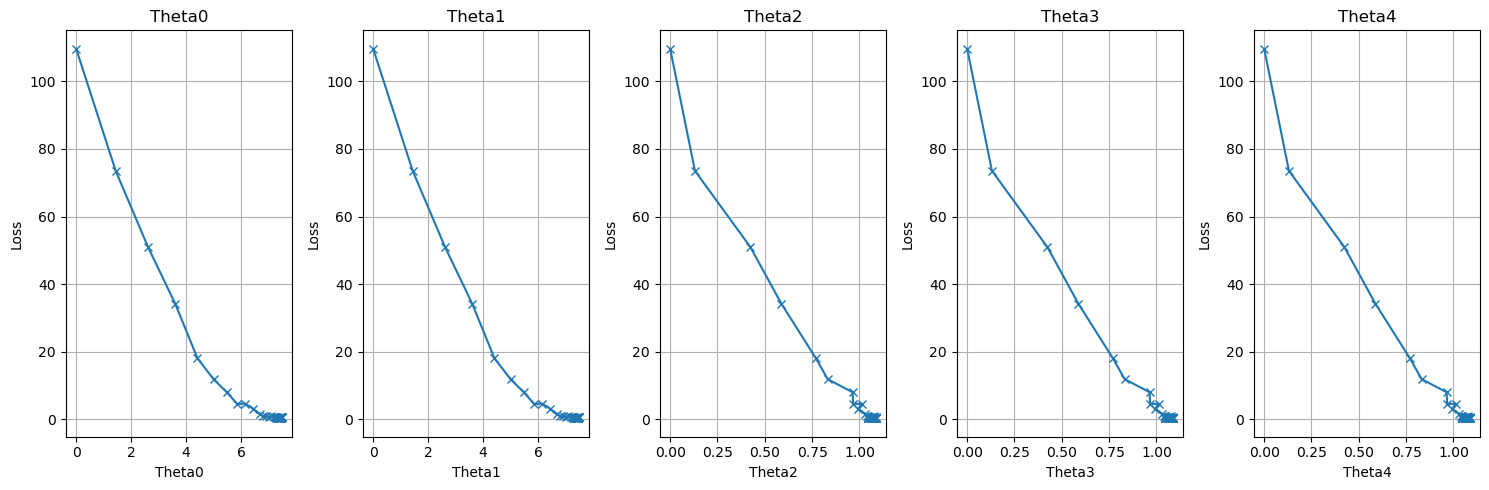

In [382]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.1, batch size = 1 (stochastic), no acceleration

In [383]:
model = MiniBatchGD(epochs=300, learning_rate=0.1, batch_size=1, accelerated=0, gamma=0)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [384]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9089084381448477
Root Mean Squared Error: 0.9810094881148316
Root Mean Squared Error for baseline: 3.2503799735966448


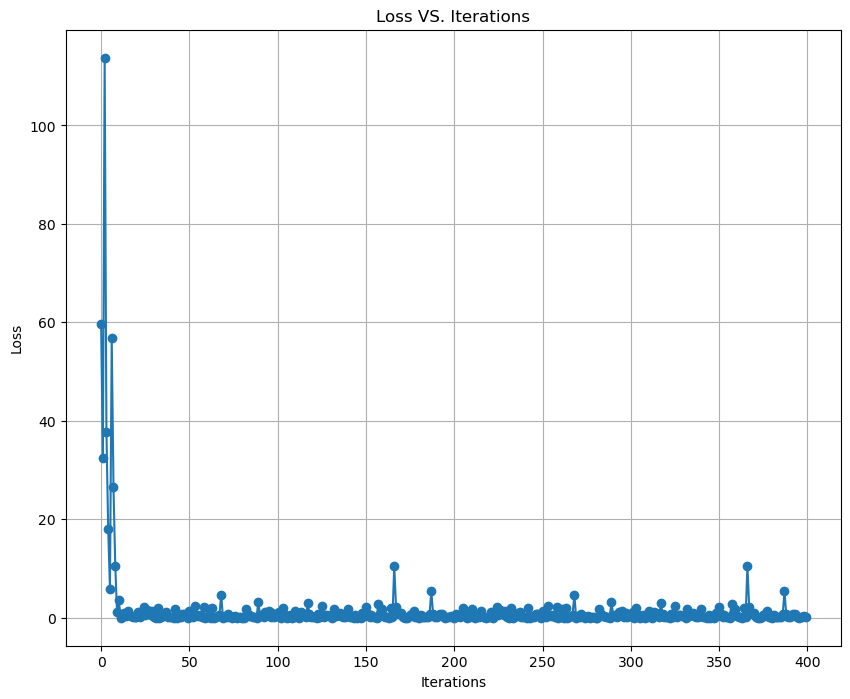

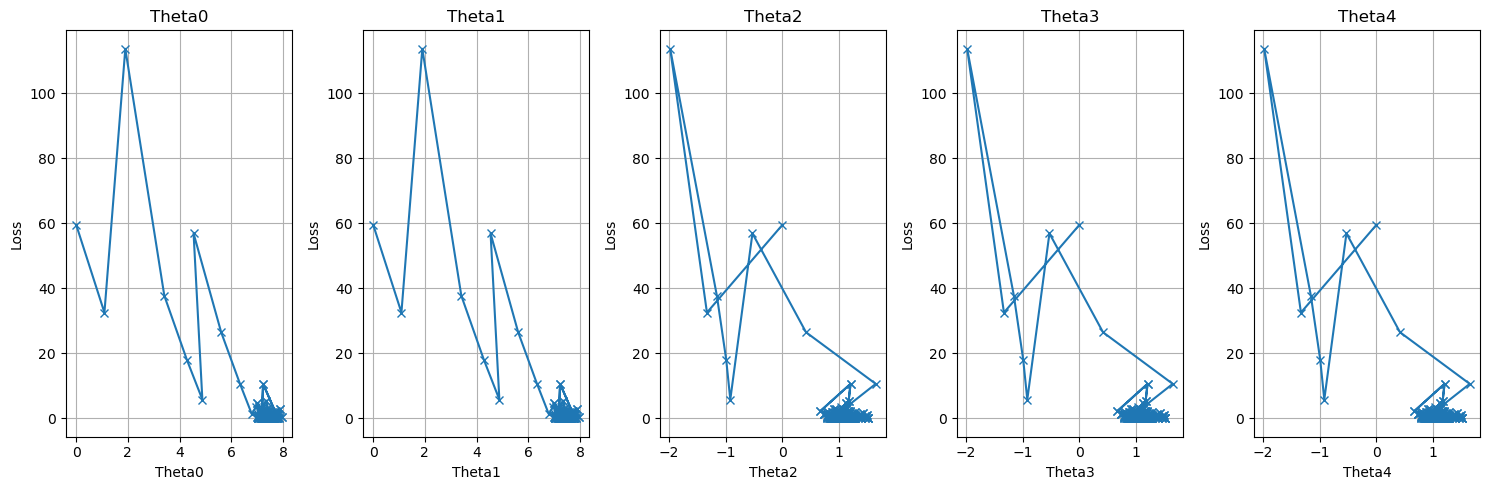

In [385]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.1, batch size = full data, momentum-based, gamma = 0.9

In [406]:
model = MiniBatchGD(epochs=300, learning_rate=0.1, batch_size=len(X_train), accelerated=1, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [407]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9030600958845609
Root Mean Squared Error: 1.0120114505980973
Root Mean Squared Error for baseline: 3.2503799735966448


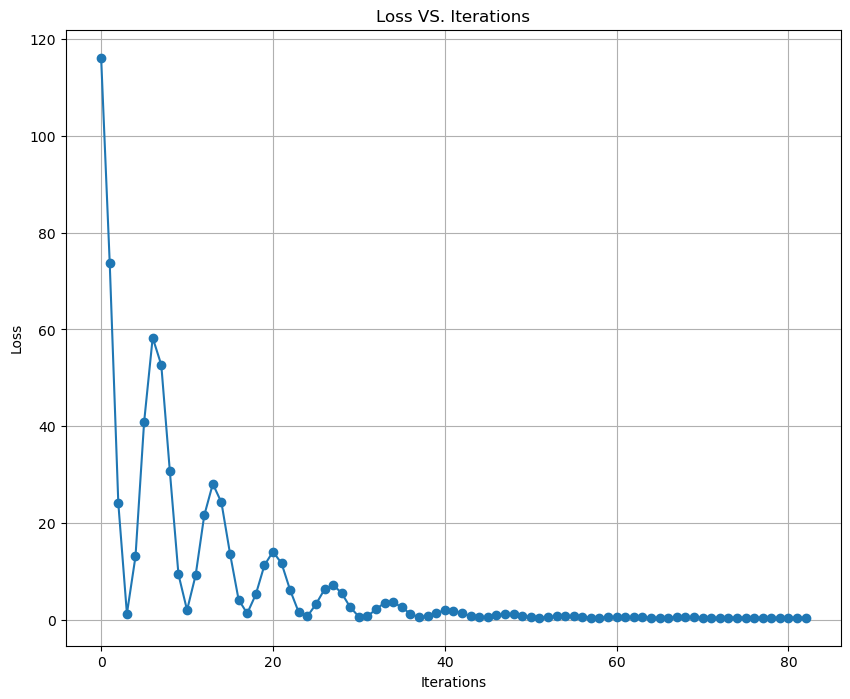

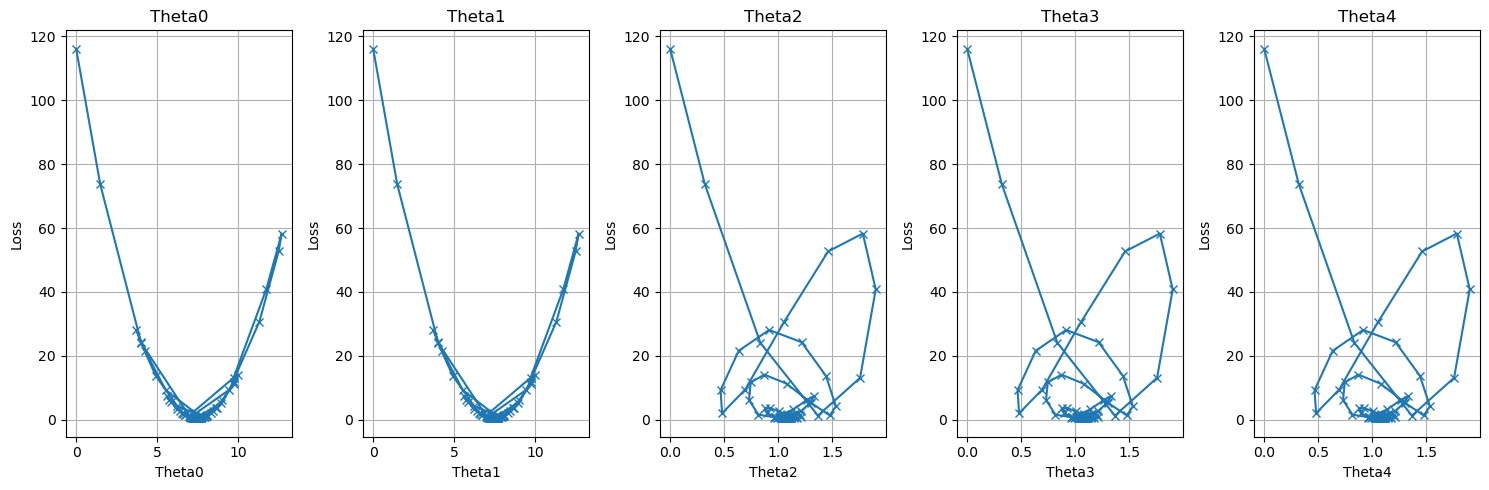

In [388]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.01, batch size = full data, momentum-based, gamma = 0.9

In [389]:
model = MiniBatchGD(epochs=300, learning_rate=0.01, batch_size=len(X_train), accelerated=1, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [390]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9079286445807405
Root Mean Squared Error: 0.9862713142718981
Root Mean Squared Error for baseline: 3.2503799735966448


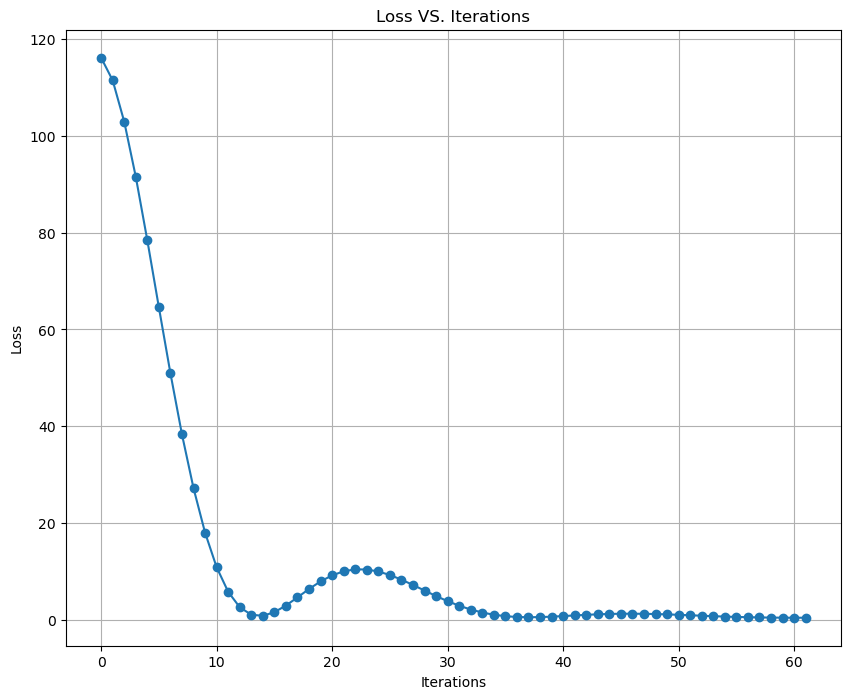

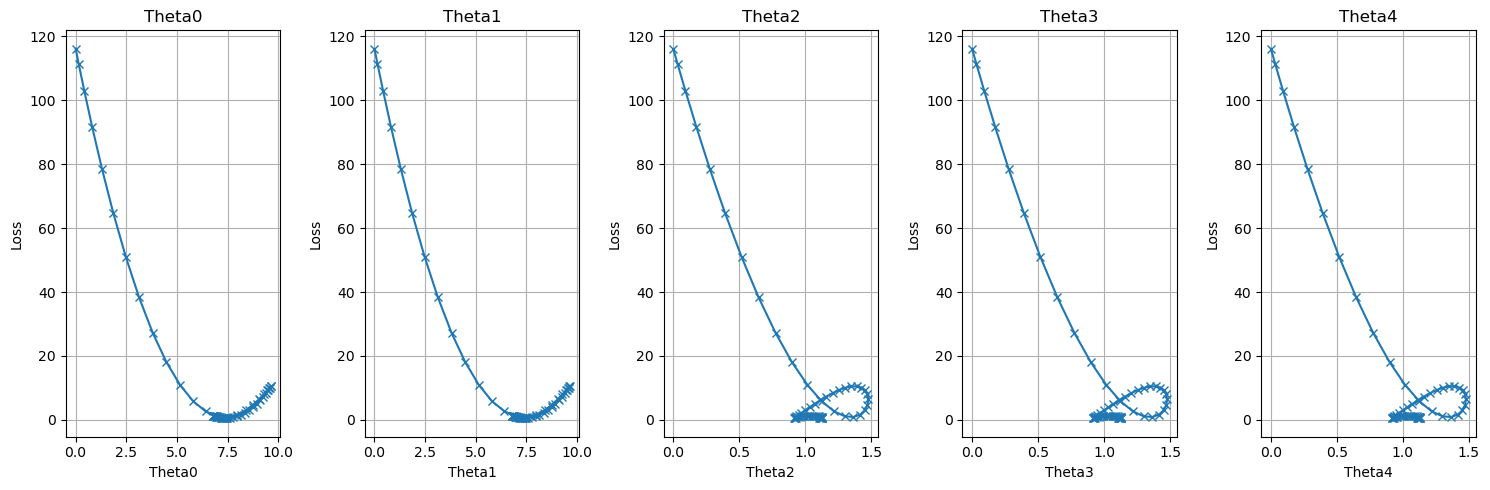

In [391]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.01, batch size = 32, momentum-based, gamma = 0.9

In [392]:
model = MiniBatchGD(epochs=300, learning_rate=0.01, batch_size=32, accelerated=1, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [393]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9058964608383814
Root Mean Squared Error: 0.9970963170991904
Root Mean Squared Error for baseline: 3.2503799735966448


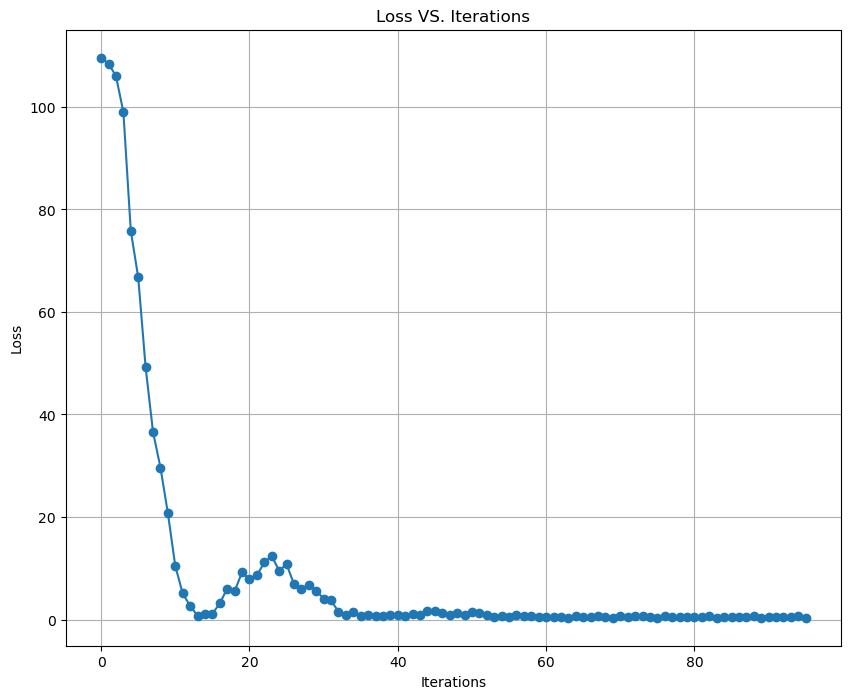

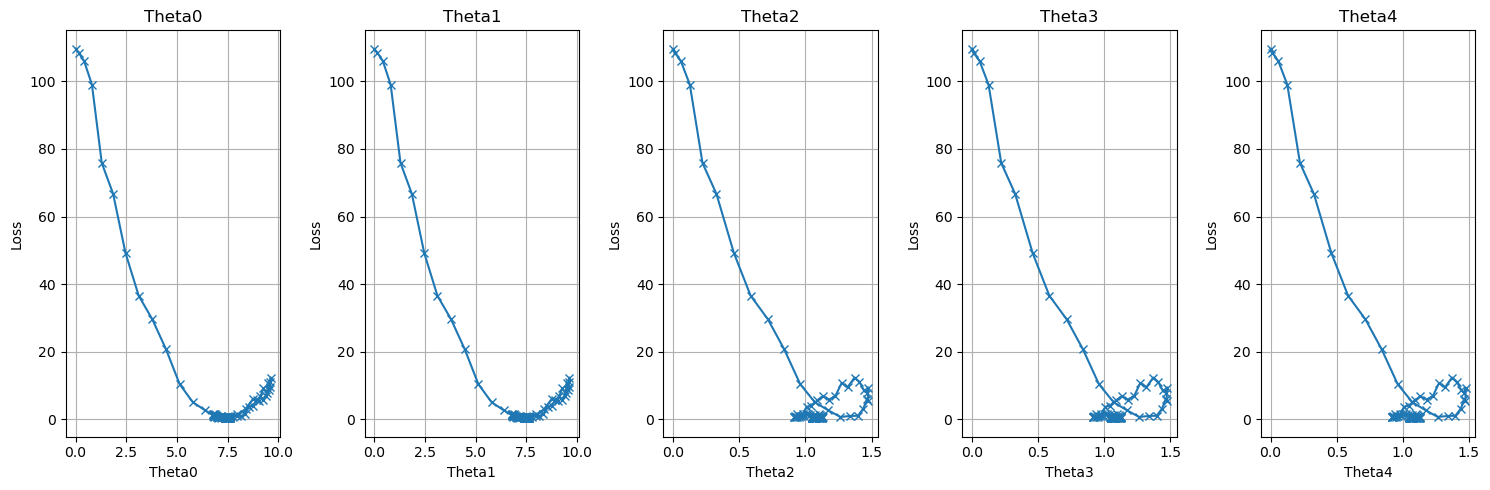

In [394]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.1, batch size = full data, NAG, gamma = 0.9

In [395]:
model = MiniBatchGD(epochs=300, learning_rate=0.1, batch_size=len(X_train), accelerated=2, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [396]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9091738850049957
Root Mean Squared Error: 0.9795790818838956
Root Mean Squared Error for baseline: 3.2503799735966448


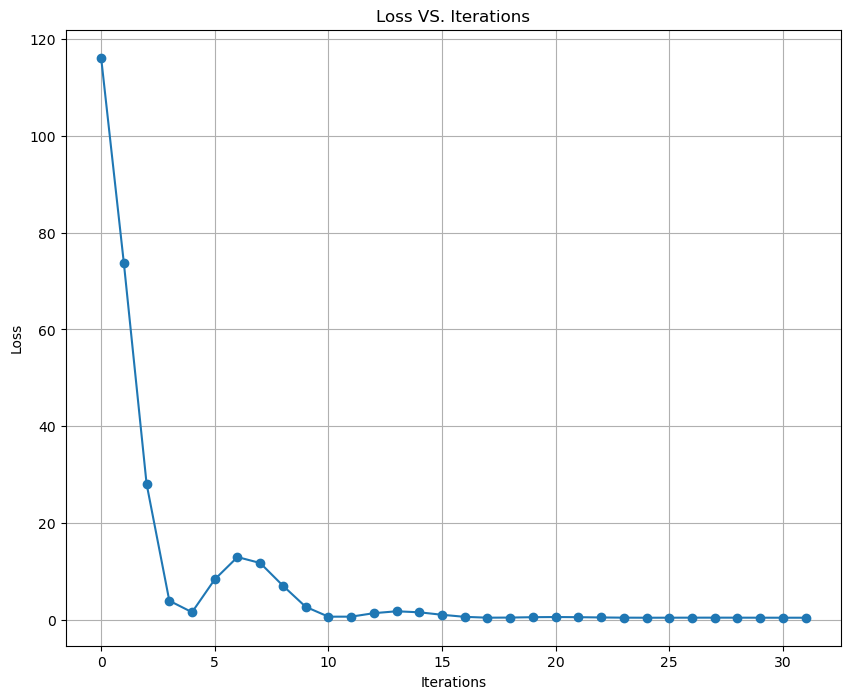

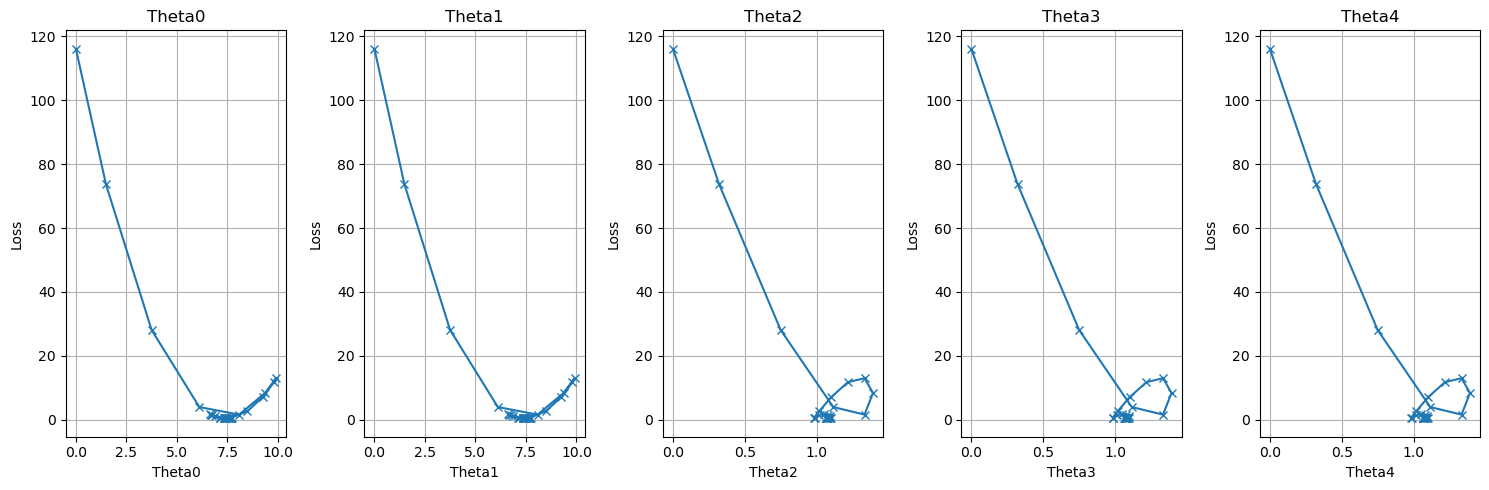

In [397]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.01, batch size = full data, NAG, gamma = 0.9

In [398]:
model = MiniBatchGD(epochs=300, learning_rate=0.01, batch_size=len(X_train), accelerated=2, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [399]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9090355226874347
Root Mean Squared Error: 0.980324931537952
Root Mean Squared Error for baseline: 3.2503799735966448


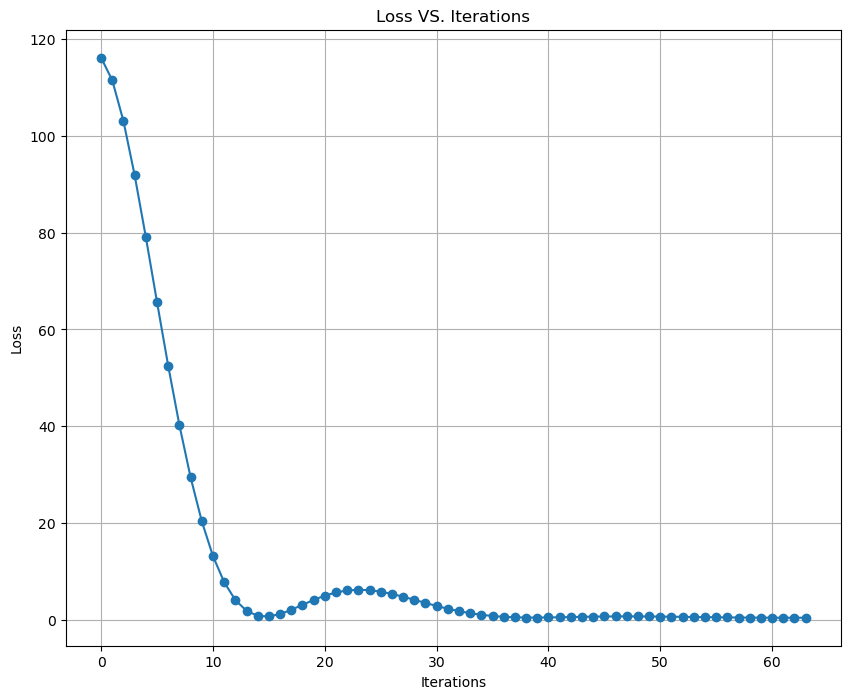

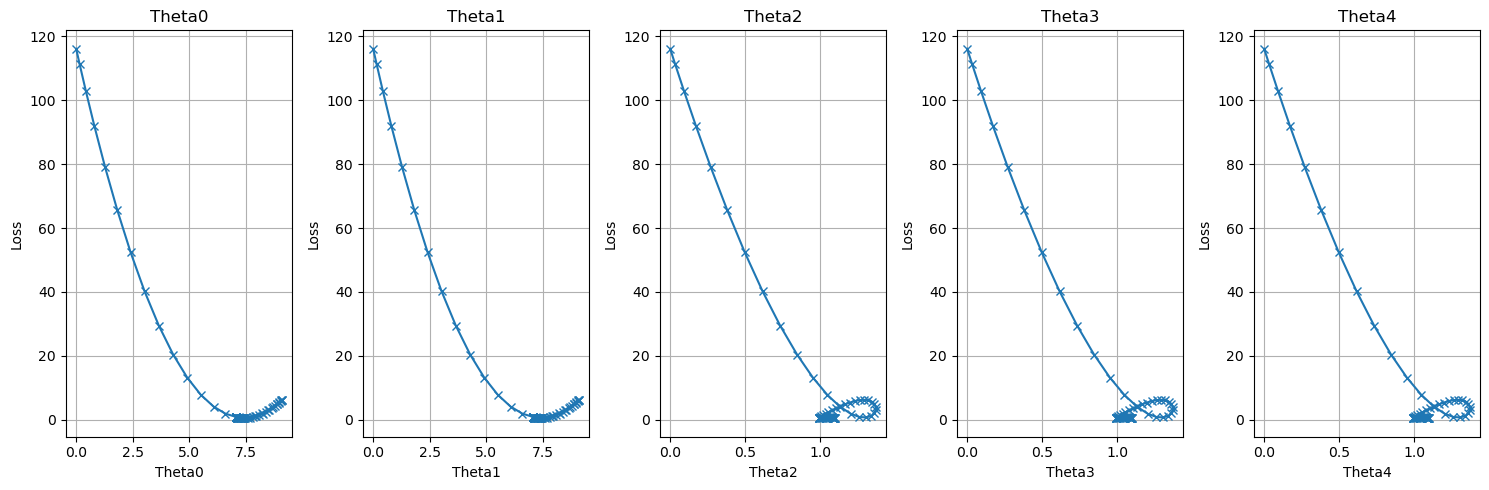

In [400]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

##### Epochs = 300, LR = 0.01, batch size = 32, NAG, gamma = 0.9

In [401]:
model = MiniBatchGD(epochs=300, learning_rate=0.01, batch_size=32, accelerated=2, gamma=0.9)
thetas, thetas_history, hx_history, cost_history, training_report = model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [402]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9126842328215948
Test R2 Score: 0.9088777379984125
Root Mean Squared Error: 0.9811747866188625
Root Mean Squared Error for baseline: 3.2503799735966448


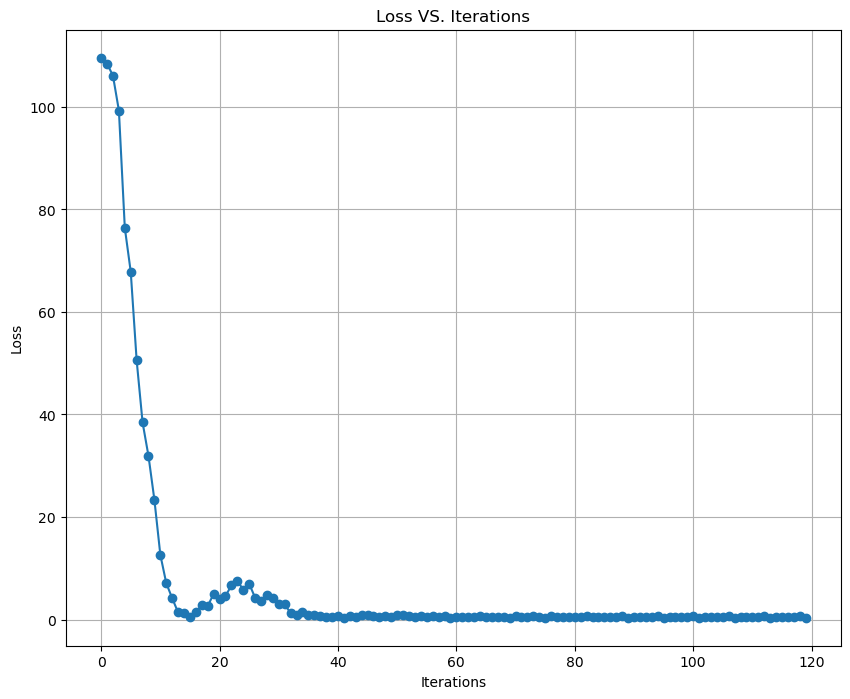

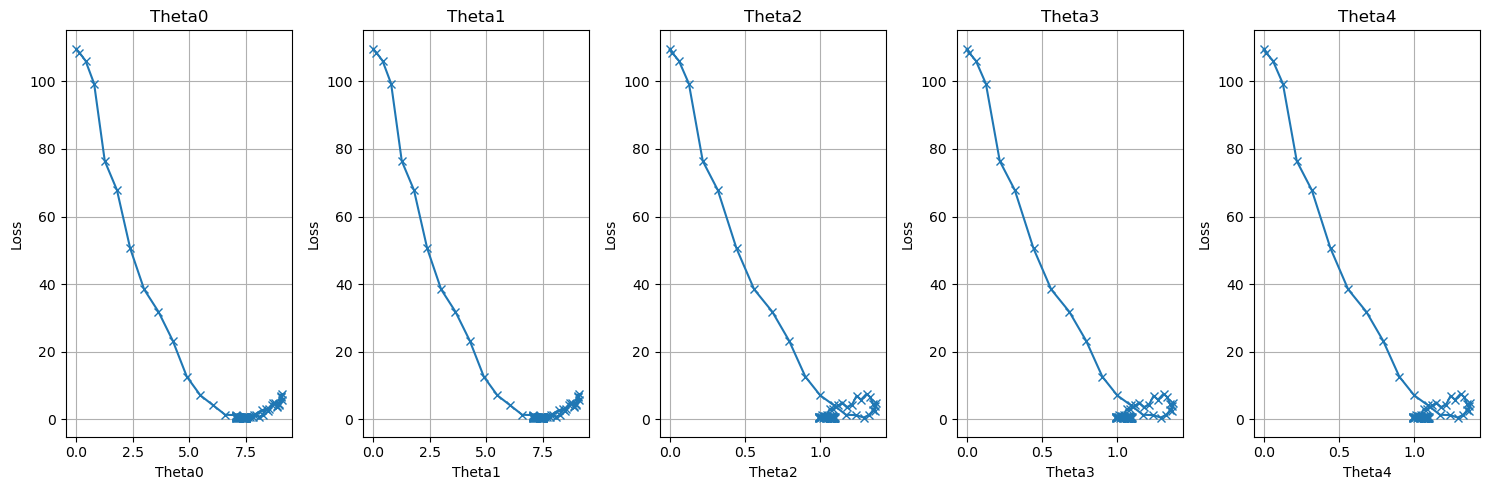

In [403]:
loss_vs_iterations(cost_history)
theta_vs_cost(thetas_history, cost_history)

### BFGS

In [318]:
def mse_gradient(theta, X, y):
    predictions = np.dot(X,theta)
    error = predictions - y
    gradient = np.dot(X.T,error) / len(y)
    return gradient

def BFGS(gradient, LR, theta_curr, theta_prev, X, y, num_iter=100, epsilon=0.001):
    y = y.reshape(-1,1)
    B_inv = np.identity(len(theta_curr))
    I = np.identity(len(theta_curr))
    gradient_prev = gradient(theta_prev, X, y)
    for i in range(num_iter):
        gradient_curr = gradient(theta_curr, X, y)
        if np.linalg.norm(gradient_curr) < epsilon:
            break
        delta_theta = theta_curr - theta_prev
        deltay = gradient_curr - gradient_prev
        repeating_term = np.dot(deltay.T, delta_theta)
        term1 = I - np.dot(delta_theta, deltay.T) / repeating_term
        term2 = I - np.dot(deltay, delta_theta.T) / repeating_term
        term3 = np.dot(delta_theta, delta_theta.T) / repeating_term

        B_inv = np.dot(term1, np.dot(B_inv, term2)) + term3
        theta_prev = theta_curr
        theta_curr = theta_curr - LR * B_inv @ gradient_curr
        gradient_prev = gradient_curr

    return theta_curr, gradient_curr, i

In [348]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [364]:
initial_theta1 = np.zeros((X_train.shape[1],1))
initial_theta2 = np.ones((X_train.shape[1],1))*0.1
learning_rate = 0.1
final_theta, final_gradient, num_iterations = BFGS(mse_gradient, learning_rate, initial_theta1, initial_theta2, X_train, y_train, num_iter=300)
print("Final Coefficients:", final_theta)
print("Final Gradient:", final_gradient)
print("Number of Iterations:", num_iterations)

Final Coefficients: [[14.86115531]
 [ 1.07087845]
 [ 1.07087845]
 [ 1.07087845]]
Final Gradient: [[-0.00090007]
 [-0.00020359]
 [-0.00020359]
 [-0.00020359]]
Number of Iterations: 92


In [365]:
coefficients = np.array(final_theta).reshape(-1, 1)
hx = np.dot(X_train, coefficients)
predictions = np.dot(X_test, coefficients)

In [366]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9128625942147558
Test R2 Score: 0.9090867687478292
Root Mean Squared Error: 0.9800487530248684
Root Mean Squared Error for baseline: 3.2503799735966448


In [367]:
# Set learning rate and perform BFGS optimization
learning_rate = 1
final_theta, final_gradient, num_iterations = BFGS(mse_gradient, learning_rate, initial_theta1, initial_theta2, X_train, y_train, num_iter=300)

# Print the results
print("Final Coefficients:", final_theta)
print("Final Gradient:", final_gradient)
print("Number of Iterations:", num_iterations)

Final Coefficients: [[14.86205878]
 [ 1.07094646]
 [ 1.07094646]
 [ 1.07094646]]
Final Gradient: [[3.40166959e-06]
 [4.25303719e-07]
 [4.25303719e-07]
 [4.25303719e-07]]
Number of Iterations: 4


In [368]:
coefficients = np.array(final_theta).reshape(-1, 1)
hx = np.dot(X_train, coefficients)
predictions = np.dot(X_test, coefficients)

In [369]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)
train = r2_score(y_train, hx)
# Print the R2 score
print(f'Train performance: {train}')
# Print the R2 score
print(f'Test R2 Score: {r2}')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
baseline_predictions = np.full_like(y_test, y_test.mean())
rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Root Mean Squared Error for baseline:", rmse)

Train performance: 0.9128626695229116
Test R2 Score: 0.9090867687478292
Root Mean Squared Error: 0.9800487530248684
Root Mean Squared Error for baseline: 3.2503799735966448
